THIS CODE IS NOT LONGER RELIABLE
It somehow produce hgiher RMSE
<h3>Don't USE

In [7]:
import numpy as np
# import pathogenprofiler as pp
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
# import fastq2matrix as fm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
from scipy.stats import norm
import subprocess
from scipy.stats import kurtosis, skew
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [80]:
vcf_file = 'test_data/ERR6634978-ERR6635032-0100.vcf.gz'
json_file = 'test_data/ERR6634978-ERR6635032-1090.results.json'

In [81]:
gm = vcf_to_mix_model(vcf_file,plot=True,tail_cutoff=0.1)


std0: 0.11129875740351634
0.6836992187547083
std1: 0.12477868352910905
0.2963206504295339


In [108]:
VCF_FILE_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20'
#/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20
JSON_FILE_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20/results'
#/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20/results

NAME_FILE='/mnt/storage7/lwang/trial_tb_philippines/data/seqtk/sample_name.txt'

In [10]:
def assign_variant_to_distrib(gm,freq,cutoff=0.95):
    probs = gm.predict_proba([[freq]])
    pred = gm.predict([[freq]])
    if probs[0][pred][0]>cutoff:
        return pred[0], probs[0][pred][0]
    else:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        return None, pred[0], probs[0][pred][0]

In [109]:
tb_profiler_predictions = []

def tb_profiler_pred(json_file):
    output = []
    json_results = json.load(open(json_file))
    for x in json_results['lineage']:
        if re.search("^lineage1.2.1$", x['lin']):
            output.append(x['frac'])
        if re.search("^lineage4.3.4$", x['lin']):
            output.append(x['frac'])
        
    if len(output) == 1:
        output.append(0)
    if output[0] < output[1]:
        temp = output[0]
        output[0] = output[1]
        output[1] = temp
    if output[0] > output[1]:
        cut_off =  output[1]/2
    else:
        cut_off =  output[-2]/2

    return output, cut_off


print(tb_profiler_pred(json_file))

([0.8633651551312649, 0.1011378002528445], 0.05056890012642225)


0.9433299899699097 0.05667001003009027


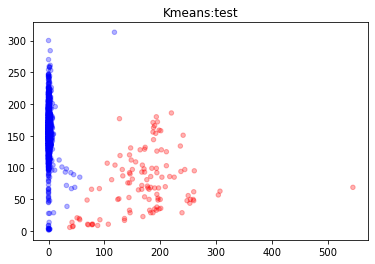

In [110]:
#Kmeans
from sklearn.cluster import KMeans

model_predictions = []

def model_pred(vcf_file, ratio='test', tail_cutoff=0.00):
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
    pos = []
    freqs = []
    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            if afs[1]>1-tail_cutoff or afs[1]<tail_cutoff:
                continue
            pos.append(int(row[0]))
            freqs.append(ads)
        # freqs = [[0.7],[0.6],[0.4]]
        km = KMeans(n_clusters=2, random_state=0, init='random').fit(freqs)
        labels = km.predict(freqs)
        mu0 = len(labels[labels==0])/len(labels)
        mu1 = len(labels[labels==1])/len(labels)

        freqs = np.array(freqs)

        # fig = px.scatter(x=freqs[:,0] ,y=freqs[:,1], color=labels)

    #     fig.update_layout(
    #         title="K-Means",
    #         xaxis_title="Ref haplotype count",
    #         yaxis_title="Alt haplotype count",
    #         legend_title="",
    #         font=dict(
    #             family="Courier New, monospace",
    #             size=18,
    #             color="RebeccaPurple"
    #     )
    # )
    #     fig.show()
        plt.figure()
        plt.scatter(freqs[:,0], freqs[:,1], c=labels, s=20, cmap='bwr', alpha=0.3)
        plt.title(f"Kmeans:{ratio}")
        print(mu0, mu1)



    if mu0 > mu1:
        return [mu0, mu1], km
    else:
        return [mu1, mu0], km

mu, km = model_pred(vcf_file)

In [111]:
#GMM
model_predictions = []

def model_pred(vcf_file, ratio='test', tail_cutoff=0.00):
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
    pos = []
    freqs = []
    scatter = []
    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            if afs[1]>1-tail_cutoff or afs[1]<tail_cutoff:
                continue
            pos.append(int(row[0]))
            scatter.append(ads)
            freqs.append([afs[1]])
        # freqs = [[0.7],[0.6],[0.4]]    
        scatter = np.array(scatter)
        gm = GaussianMixture(n_components=2, random_state=0).fit(np.array(freqs).reshape(-1, 1))
        mu0 = gm.means_[1][0]
        mu1 = gm.means_[0][0]
        labels = gm.predict(freqs)
        
        # mu0_ = len(labels[labels==0])/len(labels)
        # mu1_ = len(labels[labels==1])/len(labels)
        # plt.figure()
        # plt.scatter(scatter[:,0], scatter[:,1], c=labels, s=20, cmap='bwr', alpha=0.3)
        # plt.title(f"GMM: {ratio}, Label: {mu0_}, {mu1_}, Mu: {mu0}, {mu1}")

    if mu0 > mu1:
        return [mu0, mu1], gm
    else:
        return [mu1, mu0], gm



print(model_pred(vcf_file))


([0.9976613585401825, 0.5891451515923425], GaussianMixture(n_components=2, random_state=0))


In [112]:
def frac_MSE(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH):
    with open(NAME_FILE, 'r') as f:
        sample_list = [line.rstrip('\n') for line in f]

    sample_list_json=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.results.json')
        string = ''.join([letter for letter in x] )
        sample_list_json.append(string)
    

    sample_list_vcf=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('_q20.recode.vcf.gz')  #change here if using filtered/non-filtered samples
        string = ''.join([letter for letter in x] )
        sample_list_vcf.append(string)

    ratio = []
    for i in sample_list_json:
        temp = i.split('-')
        ratio.append(temp[2])
    
    ratio1=[]
    for i in ratio:
        temp = i.split('.')
        ratio1.append(temp[0])

    ratio = ratio1
    tb_profiler_predictions = []
    model_predictions = []

    for j, vcf, ratio in zip(sample_list_json, sample_list_vcf, ratio):
        JSON_FILE = os.path.join(JSON_FILE_PATH, j)
        tb_out_, cut_off = tb_profiler_pred(JSON_FILE)

        VCF_FILE = os.path.join(VCF_FILE_PATH, vcf)
        model_out_, gm = model_pred(vcf_file, ratio, tail_cutoff=cut_off)

        tb_profiler_predictions.extend(tb_out_)
        model_predictions.extend(model_out_)
    
    print(tb_profiler_predictions)
    print(model_predictions)
    mse_ = []
    for tb, m in zip (tb_profiler_predictions, model_predictions):
        mse_.append(mean_squared_error([tb], [m], squared=False))
    print('==========Crappy code!, this is actually MSE score==========')
    plot_f1_bar(ratio1, mse_)
    
    MSE = mean_squared_error(tb_profiler_predictions, model_predictions, squared=False)

    return MSE

<h1>MSE

In [113]:
print(frac_MSE(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH))

[0.9974779319041615, 0, 0.9240583232077765, 0, 0.9949452401010952, 0, 0.8633651551312649, 0, 0.8129839189994044, 0.141399416909621, 0.7554125219426565, 0.20933977455716588, 0.7028862478777589, 0.24958263772954925, 0.6681818181818182, 0.2986167615947925, 0.6272257323377369, 0.34077750206782464, 0.5873648264086511, 0.3963963963963964, 0.5228684359119141, 0.45028294260307195, 0.5011990407673861, 0.47477064220183485, 0.5432196669310071, 0.43852691218130313, 0.5932203389830508, 0.38841567291311757, 0.6541598694942904, 0.33860045146726864, 0.6951219512195121, 0.2962962962962963, 0.7464788732394366, 0.24119076549210205, 0.7953216374269005, 0.20209287115761937, 0.846089850249584, 0.15904292751583393, 0.9061461794019934, 0.07450980392156863, 0.9465776293823038, 0]
[0.9976613585401825, 0.5891451515923425, 0.9976613585401825, 0.5891451515923425, 0.9976613585401825, 0.5891451515923425, 0.9976613585401825, 0.5891451515923425, 0.520716757010037, 0.2598535287644475, 0.47117499048882816, 0.23384703072

0.23027523721782164


In [114]:
#removing the 0100 and 1000 6040, 5050case
y_true = [0.8633651551312649, 0.1011378002528445, 0.7554125219426565, 0.20933977455716588, 0.6681818181818182, 0.2986167615947925, 
          # 0.5873648264086511, 0.3963963963963964, 0.5011990407673861, 0.47477064220183485, 0.5932203389830508, 0.38841567291311757, 
          0.6951219512195121, 0.2962962962962963, 0.7953216374269005, 0.20057803468208094, 0.9061461794019934, 0.12028608582574772]
y_pred = [0.7660500659768188, 0.23408824816297552, 0.7659220199852712, 0.2368329200364438, 0.7633326746158897, 0.248175728926683, 
          # 0.7502904174077132, 0.2759160643977226, 0.7268216992632079, 0.3190932149543465, 0.7520835761491568, 0.2726061158130421, 
          0.7637465557502369, 0.24760025372757327, 0.7659445772369651, 0.2352338544977916, 0.7660500659768188, 0.23408824816297552]
print(len(y_true))
print(len(y_pred))
mean_squared_error(y_true, y_pred, squared=False)

12
12


0.08232703363298553

<h1>Confusion matrix

In [115]:
def confusion_map(y, y_pred, title):
    cf_matrix = confusion_matrix(y, y_pred)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    plt.title(title)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [116]:
def confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH, output=False):
    with open(NAME_FILE, 'r') as f:
        sample_list = [line.rstrip('\n') for line in f]

    sample_list_json=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.results.json')
        string = ''.join([letter for letter in x] )
        sample_list_json.append(string)
        
    sample_list_vcf=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('_q20.recode.vcf.gz')
        string = ''.join([letter for letter in x] )
        sample_list_vcf.append(string)

    ratio = []
    for i in sample_list_json:
        temp = i.split('-')
        ratio.append(temp[2])
    
    ratio1=[]
    for i in ratio:
        temp = i.split('.')
        ratio1.append(temp[0])

    ratio = ratio1

    pos_lin_0 = {'rifampicin':0, 'isoniazid':1, 'ethambutol':2}
    pos_lin_1 = {'rifampicin':0, 'streptomycin':1, 'isoniazid':2, 'ethionamide':3}
    
    ratio_list = []
    f1_list = []



    for j, vcf, ratio in zip(sample_list_json, sample_list_vcf, ratio):
        JSON_FILE = os.path.join(JSON_FILE_PATH, j)
        tb_out_, cut_off = tb_profiler_pred(JSON_FILE)

        if ratio == '0100': 
            lin_ = [0,0,0,1,1,1,1] #lineage1 with rifampicin, streptomycin, isoniazid, ethionamide resistance
        elif ratio == '1000':
            lin_ = [1,1,1,0,0,0,0] #lineage4 with rifampicin, isoniazid, ethambutol resistance
        else:
            lin_ = [1,1,1,1,1,1,1]


        VCF_FILE = os.path.join(VCF_FILE_PATH, vcf)
        model_out_, gm = model_pred(vcf_file, ratio, tail_cutoff=cut_off)

        strain0 = []
        strain1 = []
        strainU = []

        json_results = json.load(open(JSON_FILE))
        for var in json_results['dr_variants']:
            cluster = assign_variant_to_distrib(gm,var['freq'], cutoff=0.95)
            if cluster[0] == 0:
                var['probs']= cluster
                strain0.append(var)
            elif cluster[0] == 1:
                var['probs']= cluster
                strain1.append(var)
            else:
                var['probs']= cluster[1:]
                strainU.append(var)


        strain_0 = [(v['drugs'][0]['drug']) for v in strain0]
        strain_1 = [(v['drugs'][0]['drug']) for v in strain1]
        
        # print(ratio)
        # print(strain_0)
        # print(strain_1)
        
        if 'ethambutol' in strain_1:
            strain_0 = [(v['drugs'][0]['drug']) for v in strain1]
            strain_1 = [(v['drugs'][0]['drug']) for v in strain0]

        if 'streptomycin' in strain_0 or 'ethionamide' in strain_0:
            strain_1 = [(v['drugs'][0]['drug']) for v in strain0]
            strain_0 = [(v['drugs'][0]['drug']) for v in strain1]

        # strain_0 = list(set(strain_0))
        # strain_1 = list(set(strain_1))
        
        # print(ratio)
        # print(strain_0)
        # print(strain_1)
        
        strain_0_pred = [0]*3
        if 'streptomycin' in strain_0 or 'ethionamide' in strain_0:
            print(ratio,'strain_0_error', strain_0)
        else:
            for d in strain_0:
                strain_0_pred[pos_lin_0[d]] = 1

        strain_1_pred = [0]*4
        if 'ethambutol' in strain_1:
            print(ratio,'strain_1_error', strain_1)
        else:
            for d in strain_1:
                strain_1_pred[pos_lin_1[d]] = 1
        
        strain_pred = []
        strain_pred.extend(strain_0_pred)
        strain_pred.extend(strain_1_pred)
        f1 = f1_score(lin_, strain_pred)
        if output == True:
            confusion_map(lin_, strain_pred, ratio)
            print(f'f1-{ratio}:', f1)
        
        # print(lin_)
        # print(strain_pred)
        
        ratio_list.append(ratio)
        f1_list.append(f1)

    return ratio_list, f1_list

f1-0100: 0.5714285714285715
f1-0595: 0.6
f1-1000: 1.0
f1-1090: 0.6
f1-1585: 0.6
f1-2080: 0.6
f1-2575: 0.8333333333333333
f1-3070: 0.6
f1-3565: 0.6
f1-4060: 0.25
f1-4555: 0.4444444444444445
f1-5050: 0.6
f1-5545: 0.6
f1-6040: 0.6
f1-6535: 0.8333333333333333
f1-7030: 0.6
f1-7525: 0.923076923076923
f1-8020: 0.923076923076923
f1-8515: 0.8333333333333333
f1-9010: 0.6
f1-9505: 0.6


/tmp/ipykernel_14787/3340613689.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



(['0100',
  '0595',
  '1000',
  '1090',
  '1585',
  '2080',
  '2575',
  '3070',
  '3565',
  '4060',
  '4555',
  '5050',
  '5545',
  '6040',
  '6535',
  '7030',
  '7525',
  '8020',
  '8515',
  '9010',
  '9505'],
 [0.5714285714285715,
  0.6,
  1.0,
  0.6,
  0.6,
  0.6,
  0.8333333333333333,
  0.6,
  0.6,
  0.25,
  0.4444444444444445,
  0.6,
  0.6,
  0.6,
  0.8333333333333333,
  0.6,
  0.923076923076923,
  0.923076923076923,
  0.8333333333333333,
  0.6,
  0.6])

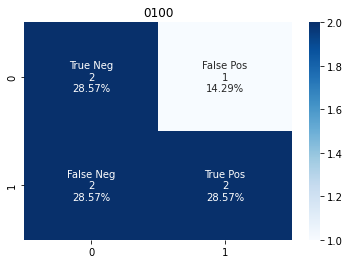

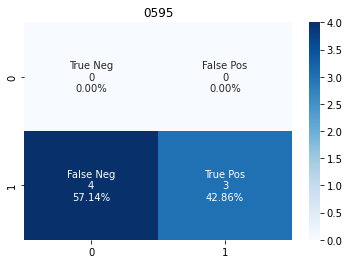

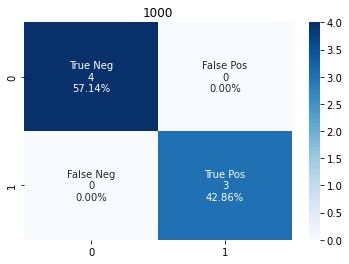

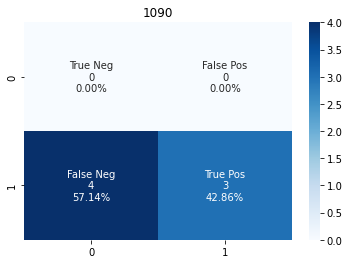

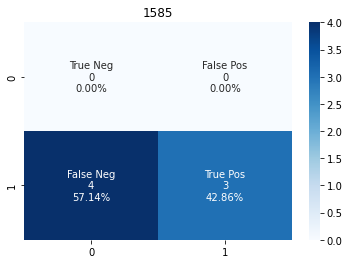

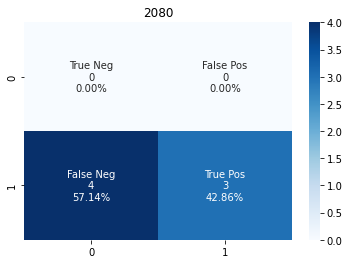

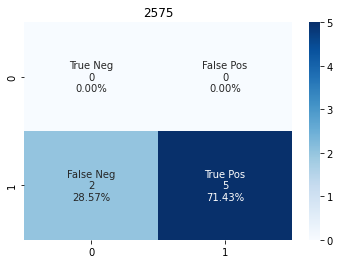

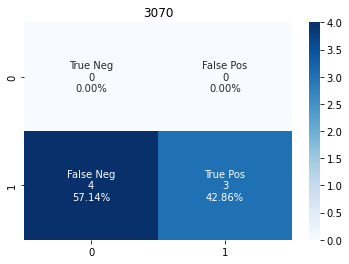

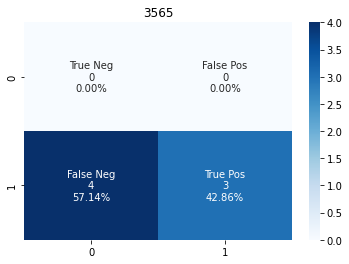

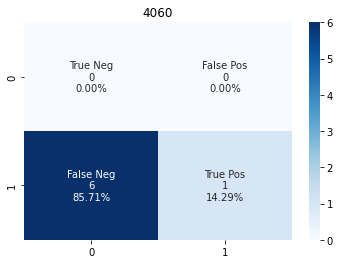

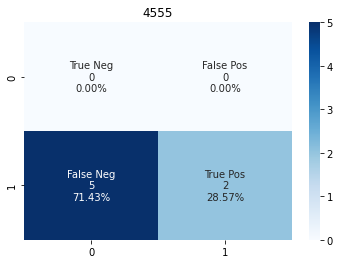

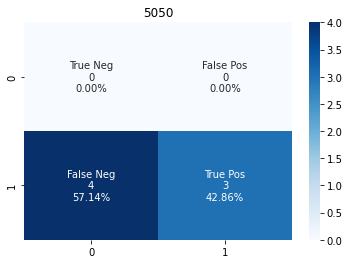

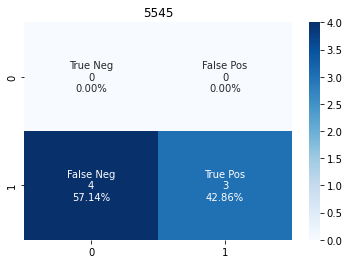

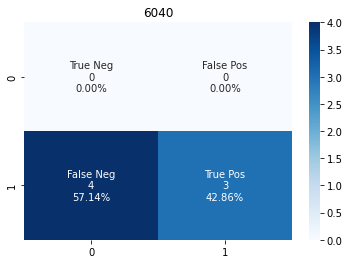

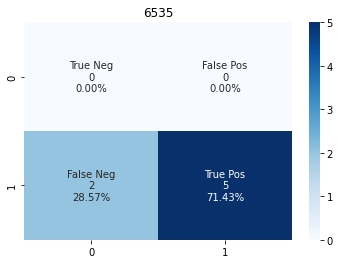

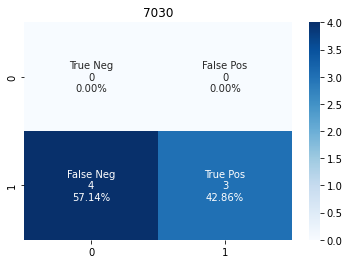

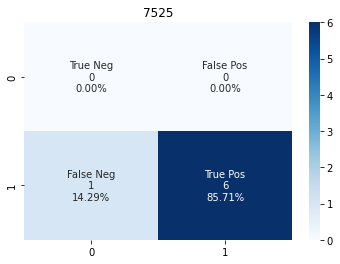

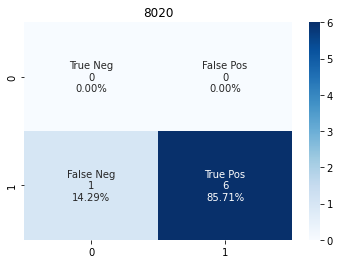

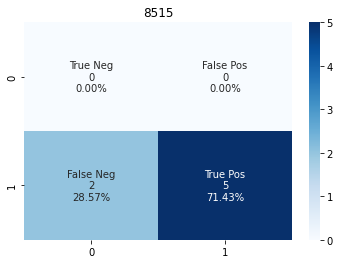

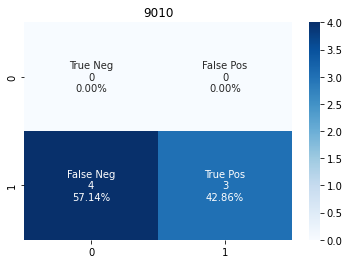

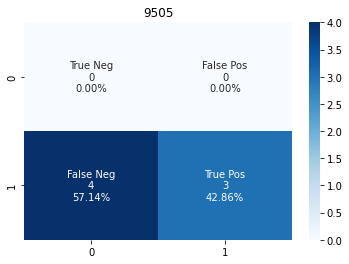

In [117]:
confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH, output=True)

In [105]:
def plot_f1_bar(ratio, f1):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ratio ,y=f1, mode='lines',))
    
    fig.update_layout(
        title="F1 score",
        xaxis_title="Strain Ratio",
        yaxis_title="F1",
        legend_title="",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )

    fig.show()

ratio, f1 = confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH)    

plot_f1_bar(ratio, f1)

In [88]:
def plot_gm(gm,data):
    gm.covariances_[0][0][0]
    std0 = np.sqrt(gm.covariances_[0][0][0]) #(n_components, n_features, n_features)
    print('std0:',std0)
    mu0 = gm.means_[0][0]
    print(mu0)
    std1 = np.sqrt(gm.covariances_[1][0][0]) #component 1?
    print('std1:',std1)
    mu1 = gm.means_[1][0]
    print(mu1)
    x = np.linspace(0, 1, 100)
    p0 = norm.pdf(x, mu0, std0)
    p1 = norm.pdf(x, mu1, std1)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Histogram(x=[x[0] for x in data]),secondary_y=False)
    fig.add_trace(go.Scatter(x=x, y=p0, mode='lines'),secondary_y=True)
    fig.add_trace(go.Scatter(x=x, y=p1, mode='lines'),secondary_y=True)
    fig.show()

In [89]:
def plot_gaussian():
    pos = []
    freqs = []
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe

    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            pos.append(int(row[0]))
            freqs.append([afs[1]])

        mean_ = np.mean([x[0] for x in freqs])
        std_ = np.std([x[0] for x in freqs])
        print('mean:', mean_)
        print('std:', std_)
        print('2sd up', mean_-2*std_)
        print('2sd down', mean_+2*std_)

        print('skew:', skew([x[0] for x in freqs]))
        print('kurtosis:', kurtosis([x[0] for x in freqs]))


        fig = make_subplots()
        fig.add_trace(go.Histogram(x=[x[0] for x in freqs]),secondary_y=False)
        fig.add_vline(mean_-2*std_, line_dash='dash',line_color='red')
        fig.add_vline(mean_+2*std_, line_dash='dash',line_color='red')

        fig.show()



In [90]:
plot_gaussian()

mean: 0.9536660924885284
std: 0.16794268617136177
2sd up 0.6177807201458049
2sd down 1.289551464831252
skew: -3.8705171384692942
kurtosis: 13.676365842600077


In [91]:
def vcf_to_mix_model(vcf_file,plot=False,tail_cutoff=0.05,title="AF Histogram",return_freqs = False):
    pos = []
    freqs = []
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe

    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            if afs[1]>1-tail_cutoff or afs[1]<tail_cutoff:
                continue
            pos.append(int(row[0]))
            freqs.append([afs[1]])
        # freqs = [[0.7],[0.6],[0.4]]    
    gm = GaussianMixture(n_components=2, random_state=0).fit(freqs)
    if plot:
        plot_gm(gm,freqs)
    if return_freqs:
        return (gm,list(zip(pos,freqs)))
    else:
        return gm



In [92]:
gm = vcf_to_mix_model(vcf_file,plot=True,tail_cutoff=0.1)


std0: 0.11129875740351634
0.6836992187547083
std1: 0.12477868352910905
0.2963206504295339


In [93]:
json_results = json.load(open(json_file))
strain0 = []
strain1 = []
strainU = []

for var in json_results['dr_variants']:
    cluster = assign_variant_to_distrib(gm,var['freq'])
    if cluster[0] == 0:
        var['probs']= cluster
        strain0.append(var)
    elif cluster[0] == 1:
        var['probs']= cluster
        strain1.append(var)
    else:
        var['probs']= cluster[1:]
        strainU.append(var)

In [94]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strain0])
for x in strain0:
    for y in x['drugs']:
        print(y['drug'])

[('rpoB', 'p.His445Leu', 0.9224137931034483, (0, 0.9998122377891878)), ('rrs', 'n.514A>T', 0.9393939393939394, (0, 0.9998681030084968)), ('fabG1', 'c.-15C>T', 0.8279569892473119, (0, 0.9985408970737873))]
rifampicin
streptomycin
isoniazid
ethionamide


In [95]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strain1])
for x in strain1:
    for y in x['drugs']:
        print(y['drug'])


[('katG', 'p.Ser315Thr', 0.12637362637362637, (1, 0.9999983552855417)), ('embB', 'p.Met306Val', 0.11180124223602485, (1, 0.9999990007535386))]
isoniazid
ethambutol


In [96]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strainU])
for x in strainU:
    for y in x['drugs']:
        print(y['drug'])

[]
